# Proyecto Final | Análisis de Datos Ene-Jun 2023 | 

### Autor: Emilio Martínez Miranda

Spotify Dataset contiene información de más de 160000 canciones entre 1921 y 2020

In [ ]:
# Librerías generales
import datetime
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly.express as px
import seaborn as sns
import sys

%matplotlib inline
from pprint import pprint
from tqdm import tqdm
from wordcloud import WordCloud

import warnings 
warnings.filterwarnings('ignore')

# Librerías Machine Learning
from scipy.optimize import curve_fit
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor
from yellowbrick.target import FeatureCorrelation

# Librerías API Spotify
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth


### API Spotify

Acceso a cuenta de Spotify

In [ ]:
client_id = '51f42dc0496a4d78bb42be9ec2f6795d'
client_secret = '349536fc4dd8423b8afcf06e713e0c7c'
client_credentials_manager = SpotifyClientCredentials(client_id=client_id,
                                                      client_secret=client_secret)
auth_manager = SpotifyOAuth(client_id=client_id,
                            client_secret=client_secret,
                            scope='user-library-read',
                            redirect_uri='http://localhost:8888/callback')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager, auth_manager=auth_manager)

Acceso a playlist y creación de dataset

In [ ]:
# Obtención de playlist
playlist = sp.playlist(playlist_id=playlist_URI)

# Estructura para almacenar las canciones
playlist_data = {
    'name': playlist['name'],
    'tracks': []
}

In [ ]:
playlist['tracks']['total']

1561

In [ ]:
# Obtención de playlist
playlist = sp.playlist(playlist_id=playlist_URI)

# Estructura para almacenar las canciones
playlist_data = {
    'name': playlist['name'],
    'tracks': []
}

# identificadores de las canciones 
track_ids = [track['track']['id'] for track in playlist['tracks']['items']]
# características de las canciones
audio_features = sp.audio_features(track_ids)


for idx, track in enumerate(playlist['tracks']['items']): 
    features = next(item for item in audio_features if item['id'] == track['track']['id'])
    track_data = {
        'pos': idx + 1,
        'track_name': track['track']['name'],
        'album_name': track['track']['album']['name'],
        'artist_name': track['track']['artists'][0]['name'],
        'release_date': track['track']['album']['release_date'],
        'track_uri': track['track']['uri'],
        'album_uri': track['track']['album']['uri'],
        'artist_uri': track['track']['artists'][0]['uri'],
        'duration_ms': track['track']['duration_ms'],
        'explicit': track['track']['explicit'],
        'popularity': track['track']['popularity'],
        'id': track['track']['id'],
        'key': features['key'],
        'valence': features['valence'],
        'acousticness': features['acousticness'],
        'danceability': features['danceability'],
        'energy': features['energy'],
        'instrumentalness': features['instrumentalness'],
        'liveness': features['liveness'],
        'loudness': features['loudness'],
        'mode': features['mode'],
        'speechiness': features['speechiness'],
        'tempo': features['tempo']
    }
    playlist_data['tracks'].append(track_data)



In [ ]:
len(playlist_data['tracks'])

100

In [ ]:
playlist_data['tracks'][99]

{'pos': 100,
 'track_name': 'EYES',
 'album_name': 'EYES',
 'artist_name': 'The Blaze',
 'release_date': '2022-06-09',
 'track_uri': 'spotify:track:4ipoHe6bjN9IeXr8CGJYgR',
 'album_uri': 'spotify:album:3Q5Eggq49qEGPF4ag1e0fO',
 'artist_uri': 'spotify:artist:1Dt1UKLtrJIW1xxRBejjos',
 'duration_ms': 212080,
 'explicit': False,
 'popularity': 62,
 'id': '4ipoHe6bjN9IeXr8CGJYgR',
 'key': 0,
 'valence': 0.119,
 'acousticness': 0.175,
 'danceability': 0.818,
 'energy': 0.433,
 'instrumentalness': 0.00413,
 'liveness': 0.124,
 'loudness': -10.853,
 'mode': 1,
 'speechiness': 0.0702,
 'tempo': 119.993}

Playlist en archivo JSON

In [ ]:
playlist_json = 'playlist.json'

with open(playlist_json, 'w') as f:
    json.dump(playlist_data, f, indent=4)

Normalización de datos

In [ ]:
with open(playlist_json, 'r') as archivo:
    playlist = json.load(archivo)

# Normalización de los datos
df = pd.json_normalize(playlist, record_path='tracks')
df

,pos,track_name,album_name,artist_name,release_date,track_uri,album_uri,artist_uri,duration_ms,explicit,...,valence,acousticness,danceability,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo
0,1,dystopia - CLUBZ Remix,dystopia (CLUBZ Remix),GRLS,2021-12-08,spotify:track:60RzxrGjFjAwuKLHvPE5Tz,spotify:album:22OpoO9jA0C5hiv0NTS9v0,spotify:artist:6hH7QHJ88Vy6KKiWANlIam,194086,False,...,0.5730,0.1120,0.937,0.573,0.008050,0.1110,-9.524,0,0.2380,115.020
1,2,She Got A Man,The Juice: Vol. III,Emotional Oranges,2022-12-09,spotify:track:13b1K3CMI8ty3By3bPMRdD,spotify:album:3n0tNdtuPGksNxuAncvMnM,spotify:artist:12trz2INGglrKMzLmg0y2C,166498,False,...,0.8800,0.3240,0.773,0.510,0.012200,0.0619,-7.402,0,0.0787,121.941
2,3,PRIDE.,DAMN.,Kendrick Lamar,2017-04-14,spotify:track:6IZvVAP7VPPnsGX6bvgkqg,spotify:album:4eLPsYPBmXABThSJ821sqY,spotify:artist:2YZyLoL8N0Wb9xBt1NhZWg,275253,True,...,0.3700,0.0786,0.665,0.535,0.000017,0.1540,-7.056,0,0.0572,138.842
3,4,Lost Cause,Happier Than Ever,Billie Eilish,2021-07-30,spotify:track:4191RXFPa7Ge9XkA4cWlna,spotify:album:0JGOiO34nwfUdDrD612dOp,spotify:artist:6qqNVTkY8uBg9cP3Jd7DAH,212496,True,...,0.5220,0.7020,0.526,0.334,0.007820,0.0586,-8.491,0,0.2510,74.966
4,5,Distance (The Algorithm Remix),Summit,Boucle Infinie,2022-08-21,spotify:track:2DNPL5bhXghPvytzK9mqdd,spotify:album:1au1XG2AdakLtj9TPPNoSc,spotify:artist:1GHPb8Q7BpKy5BDf59XvSF,200785,False,...,0.0574,0.0456,0.615,0.767,0.861000,0.1910,-10.631,1,0.0604,140.023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,Digital Sunset,Tako Tsubo,L'Impératrice,2021-03-26,spotify:track:5KQPLoxBkpzJMYulVxTR5u,spotify:album:7gE23KRzNbXeB6nZmQVqa3,spotify:artist:4PwlsrN0t5mLN0C827cbEU,201471,False,...,0.3510,0.1470,0.683,0.318,0.011300,0.1360,-10.810,1,0.0470,136.118
96,97,Anthem,Seize the Power,YONAKA,2021-07-15,spotify:track:23Z6JttaqkoqxqbAWArFqO,spotify:album:2QgPGKzoN51qcEzGlHYk7j,spotify:artist:3Wcyta3gkOdQ4TfY0WyZpu,228847,False,...,0.1180,0.0593,0.232,0.337,0.000000,0.1440,-8.068,0,0.0292,72.939
97,98,My Way,My Way,SIAMES,2022-09-16,spotify:track:2aG8speTt7aje2gii3g6UK,spotify:album:4bTBjP3iiEypRH21Q5RzEu,spotify:artist:68NOjWuVYBRXzYwhel3jAl,179151,False,...,0.5840,0.0128,0.757,0.676,0.012800,0.1240,-6.309,0,0.0324,123.030
98,99,Eden,Yoga Horror,Babel,2022-03-04,spotify:track:0HT1eAEMR6igNDMpHvZNqU,spotify:album:5Bynuoj2T6zEGdTDYhoSYQ,spotify:artist:4qrLovyKfCeNbEdN0Tmx1Q,248252,False,...,0.1420,0.0162,0.608,0.720,0.824000,0.0990,-10.052,0,0.0354,108.988


Archivo JSON a CSV

In [ ]:
df.to_csv('raw_data.csv')


Extracción de características de las canciones

In [ ]:
df_p = pd.read_csv('raw_data.csv')
df_p

,Unnamed: 0,pos,track_name,album_name,artist_name,release_date,track_uri,album_uri,artist_uri,duration_ms,...,valence,acousticness,danceability,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo
0,0,1,dystopia - CLUBZ Remix,dystopia (CLUBZ Remix),GRLS,2021-12-08,spotify:track:60RzxrGjFjAwuKLHvPE5Tz,spotify:album:22OpoO9jA0C5hiv0NTS9v0,spotify:artist:6hH7QHJ88Vy6KKiWANlIam,194086,...,0.5730,0.1120,0.937,0.573,0.008050,0.1110,-9.524,0,0.2380,115.020
1,1,2,She Got A Man,The Juice: Vol. III,Emotional Oranges,2022-12-09,spotify:track:13b1K3CMI8ty3By3bPMRdD,spotify:album:3n0tNdtuPGksNxuAncvMnM,spotify:artist:12trz2INGglrKMzLmg0y2C,166498,...,0.8800,0.3240,0.773,0.510,0.012200,0.0619,-7.402,0,0.0787,121.941
2,2,3,PRIDE.,DAMN.,Kendrick Lamar,2017-04-14,spotify:track:6IZvVAP7VPPnsGX6bvgkqg,spotify:album:4eLPsYPBmXABThSJ821sqY,spotify:artist:2YZyLoL8N0Wb9xBt1NhZWg,275253,...,0.3700,0.0786,0.665,0.535,0.000017,0.1540,-7.056,0,0.0572,138.842
3,3,4,Lost Cause,Happier Than Ever,Billie Eilish,2021-07-30,spotify:track:4191RXFPa7Ge9XkA4cWlna,spotify:album:0JGOiO34nwfUdDrD612dOp,spotify:artist:6qqNVTkY8uBg9cP3Jd7DAH,212496,...,0.5220,0.7020,0.526,0.334,0.007820,0.0586,-8.491,0,0.2510,74.966
4,4,5,Distance (The Algorithm Remix),Summit,Boucle Infinie,2022-08-21,spotify:track:2DNPL5bhXghPvytzK9mqdd,spotify:album:1au1XG2AdakLtj9TPPNoSc,spotify:artist:1GHPb8Q7BpKy5BDf59XvSF,200785,...,0.0574,0.0456,0.615,0.767,0.861000,0.1910,-10.631,1,0.0604,140.023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,96,Digital Sunset,Tako Tsubo,L'Impératrice,2021-03-26,spotify:track:5KQPLoxBkpzJMYulVxTR5u,spotify:album:7gE23KRzNbXeB6nZmQVqa3,spotify:artist:4PwlsrN0t5mLN0C827cbEU,201471,...,0.3510,0.1470,0.683,0.318,0.011300,0.1360,-10.810,1,0.0470,136.118
96,96,97,Anthem,Seize the Power,YONAKA,2021-07-15,spotify:track:23Z6JttaqkoqxqbAWArFqO,spotify:album:2QgPGKzoN51qcEzGlHYk7j,spotify:artist:3Wcyta3gkOdQ4TfY0WyZpu,228847,...,0.1180,0.0593,0.232,0.337,0.000000,0.1440,-8.068,0,0.0292,72.939
97,97,98,My Way,My Way,SIAMES,2022-09-16,spotify:track:2aG8speTt7aje2gii3g6UK,spotify:album:4bTBjP3iiEypRH21Q5RzEu,spotify:artist:68NOjWuVYBRXzYwhel3jAl,179151,...,0.5840,0.0128,0.757,0.676,0.012800,0.1240,-6.309,0,0.0324,123.030
98,98,99,Eden,Yoga Horror,Babel,2022-03-04,spotify:track:0HT1eAEMR6igNDMpHvZNqU,spotify:album:5Bynuoj2T6zEGdTDYhoSYQ,spotify:artist:4qrLovyKfCeNbEdN0Tmx1Q,248252,...,0.1420,0.0162,0.608,0.720,0.824000,0.0990,-10.052,0,0.0354,108.988


### Datasets y Exploración

In [ ]:
# Lectura de datasets
df_data = pd.read_csv('data.csv')

# Dimensiones de datasets
print('df_data: ', df_data.shape)

In [ ]:
df_data.head(3)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,key,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo
0,0.0594,1921,0.982,"['Sergei Rachmaninoff', 'James Levine', 'Berli...",0.279,831667,0.211,0,4BJqT0PrAfrxzMOxytFOIz,0.878,10,0.665,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954
1,0.9630,1921,0.732,['Dennis Day'],0.819,180533,0.341,0,7xPhfUan2yNtyFG0cUWkt8,0.000,7,0.160,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936
2,0.0394,1921,0.961,['KHP Kridhamardawa Karaton Ngayogyakarta Hadi...,0.328,500062,0.166,0,1o6I8BglA6ylDMrIELygv1,0.913,3,0.101,-14.850,1,Gati Bali,5,1921,0.0339,110.339


In [ ]:
df_data.describe()

,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
count,170653.000000,170653.000000,170653.000000,170653.000000,1.706530e+05,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000
mean,0.528587,1976.787241,0.502115,0.537396,2.309483e+05,0.482389,0.084575,0.167010,5.199844,0.205839,-11.467990,0.706902,31.431794,0.098393,116.861590
std,0.263171,25.917853,0.376032,0.176138,1.261184e+05,0.267646,0.278249,0.313475,3.515094,0.174805,5.697943,0.455184,21.826615,0.162740,30.708533
min,0.000000,1921.000000,0.000000,0.000000,5.108000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000
25%,0.317000,1956.000000,0.102000,0.415000,1.698270e+05,0.255000,0.000000,0.000000,2.000000,0.098800,-14.615000,0.000000,11.000000,0.034900,93.421000
50%,0.540000,1977.000000,0.516000,0.548000,2.074670e+05,0.471000,0.000000,0.000216,5.000000,0.136000,-10.580000,1.000000,33.000000,0.045000,114.729000
75%,0.747000,1999.000000,0.893000,0.668000,2.624000e+05,0.703000,0.000000,0.102000,8.000000,0.261000,-7.183000,1.000000,48.000000,0.075600,135.537000
max,1.000000,2020.000000,0.996000,0.988000,5.403500e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,100.000000,0.970000,243.507000


In [ ]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170653 entries, 0 to 170652
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   valence           170653 non-null  float64
 1   year              170653 non-null  int64  
 2   acousticness      170653 non-null  float64
 3   artists           170653 non-null  object 
 4   danceability      170653 non-null  float64
 5   duration_ms       170653 non-null  int64  
 6   energy            170653 non-null  float64
 7   explicit          170653 non-null  int64  
 8   id                170653 non-null  object 
 9   instrumentalness  170653 non-null  float64
 10  key               170653 non-null  int64  
 11  liveness          170653 non-null  float64
 12  loudness          170653 non-null  float64
 13  mode              170653 non-null  int64  
 14  name              170653 non-null  object 
 15  popularity        170653 non-null  int64  
 16  release_date      17

No hay valores nulos

### Limpieza de datos

In [ ]:
# Duración en milisegundos a duración en segundos
df_data['duration_min'] = df_data['duration_ms']/60000
df_data['duration_min'] = df_data['duration_min'].round(2)

df_data['duration_min'].head(3)

0    13.86
1     3.01
2     8.33
Name: duration_min, dtype: float64

In [ ]:
# Cambio de formato en nombre de artistas
df_data['artists'] = df_data['artists'].str.replace('[','')
df_data['artists'] = df_data['artists'].str.replace(']','')
df_data['artists'] = df_data['artists'].str.replace("'",'')

df_data['artists'].head()

0    Sergei Rachmaninoff, James Levine, Berliner Ph...
1                                           Dennis Day
2    KHP Kridhamardawa Karaton Ngayogyakarta Hadini...
3                                         Frank Parker
4                                           Phil Regan
Name: artists, dtype: object

In [ ]:
# Columna decada de la canción en el dataset
df_data['song_decade'] = None

df_data.loc[(df_data['year'] >= 1920) & (df_data['year'] < 1930), 'song_decade'] = '1920s'
df_data.loc[(df_data['year'] >= 1930) & (df_data['year'] < 1940), 'song_decade'] = '1930s'
df_data.loc[(df_data['year'] >= 1940) & (df_data['year'] < 1950), 'song_decade'] = '1940s'
df_data.loc[(df_data['year'] >= 1950) & (df_data['year'] < 1960), 'song_decade'] = '1950s'
df_data.loc[(df_data['year'] >= 1960) & (df_data['year'] < 1970), 'song_decade'] = '1960s'
df_data.loc[(df_data['year'] >= 1970) & (df_data['year'] < 1980), 'song_decade'] = '1970s'
df_data.loc[(df_data['year'] >= 1980) & (df_data['year'] < 1990), 'song_decade'] = '1980s'
df_data.loc[(df_data['year'] >= 1990) & (df_data['year'] < 2000), 'song_decade'] = '1990s'
df_data.loc[(df_data['year'] >= 2000) & (df_data['year'] < 2010), 'song_decade'] = '2000s'
df_data.loc[(df_data['year'] >= 2010) & (df_data['year'] < 2020), 'song_decade'] = '2010s'
df_data.loc[(df_data['year'] >= 2020) & (df_data['year'] < 2030), 'song_decade'] = '2020s'

df_data.head(-1)

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,id,instrumentalness,...,liveness,loudness,mode,name,popularity,release_date,speechiness,tempo,duration_min,song_decade
0,0.0594,1921,0.98200,"Sergei Rachmaninoff, James Levine, Berliner Ph...",0.279,831667,0.21100,0,4BJqT0PrAfrxzMOxytFOIz,0.878000,...,0.6650,-20.096,1,"Piano Concerto No. 3 in D Minor, Op. 30: III. ...",4,1921,0.0366,80.954,13.86,1920s
1,0.9630,1921,0.73200,Dennis Day,0.819,180533,0.34100,0,7xPhfUan2yNtyFG0cUWkt8,0.000000,...,0.1600,-12.441,1,Clancy Lowered the Boom,5,1921,0.4150,60.936,3.01,1920s
2,0.0394,1921,0.96100,KHP Kridhamardawa Karaton Ngayogyakarta Hadini...,0.328,500062,0.16600,0,1o6I8BglA6ylDMrIELygv1,0.913000,...,0.1010,-14.850,1,Gati Bali,5,1921,0.0339,110.339,8.33,1920s
3,0.1650,1921,0.96700,Frank Parker,0.275,210000,0.30900,0,3ftBPsC5vPBKxYSee08FDH,0.000028,...,0.3810,-9.316,1,Danny Boy,3,1921,0.0354,100.109,3.50,1920s
4,0.2530,1921,0.95700,Phil Regan,0.418,166693,0.19300,0,4d6HGyGT8e121BsdKmw9v6,0.000002,...,0.2290,-10.096,1,When Irish Eyes Are Smiling,2,1921,0.0380,101.665,2.78,1920s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170647,0.0838,2020,0.97400,Najma Wallin,0.175,133500,0.00759,0,6RuFOroO9VO0aMGEzirLHk,0.925000,...,0.1130,-35.072,1,Med slutna ögon,70,2020-02-21,0.0454,70.872,2.22,2020s
170648,0.6080,2020,0.08460,"Anuel AA, Daddy Yankee, KAROL G, Ozuna, J Balvin",0.786,301714,0.80800,0,0KkIkfsLEJbrcIhYsCL7L5,0.000289,...,0.0822,-3.702,1,China,72,2020-05-29,0.0881,105.029,5.03,2020s
170649,0.7340,2020,0.20600,Ashnikko,0.717,150654,0.75300,0,0OStKKAuXlxA0fMH54Qs6E,0.000000,...,0.1010,-6.020,1,Halloweenie III: Seven Days,68,2020-10-23,0.0605,137.936,2.51,2020s
170650,0.6370,2020,0.10100,MAMAMOO,0.634,211280,0.85800,0,4BZXVFYCb76Q0Klojq4piV,0.000009,...,0.2580,-2.226,0,AYA,76,2020-11-03,0.0809,91.688,3.52,2020s


In [ ]:
df_data.shape

(170653, 21)

#### Eliminación de Duplicados

In [ ]:
df_data.duplicated().any().sum()

0

no hay duplicados por el atributo id que es único

In [ ]:
# Eliminación de columnas con valores únicos
df_data = df_data.drop(['id', 'release_date', 'duration_ms'], axis=1)
df_data.shape

(170653, 18)

In [ ]:
df_data.duplicated().sum()

565

In [ ]:
# Eliminación de duplicados
df_data = df_data[~df_data.duplicated()==1]
df_data.shape

(170088, 18)

In [ ]:
df_data.duplicated().sum()

0

### Visualización de datos

In [ ]:
plt.rcParams.update({'font.size': 22})

In [ ]:
#sns.displot(df_data)
#plt.show()

In [ ]:
# sns.pairplot(df_data)
# plt.show()

<Axes: xlabel='mode', ylabel='Density'>

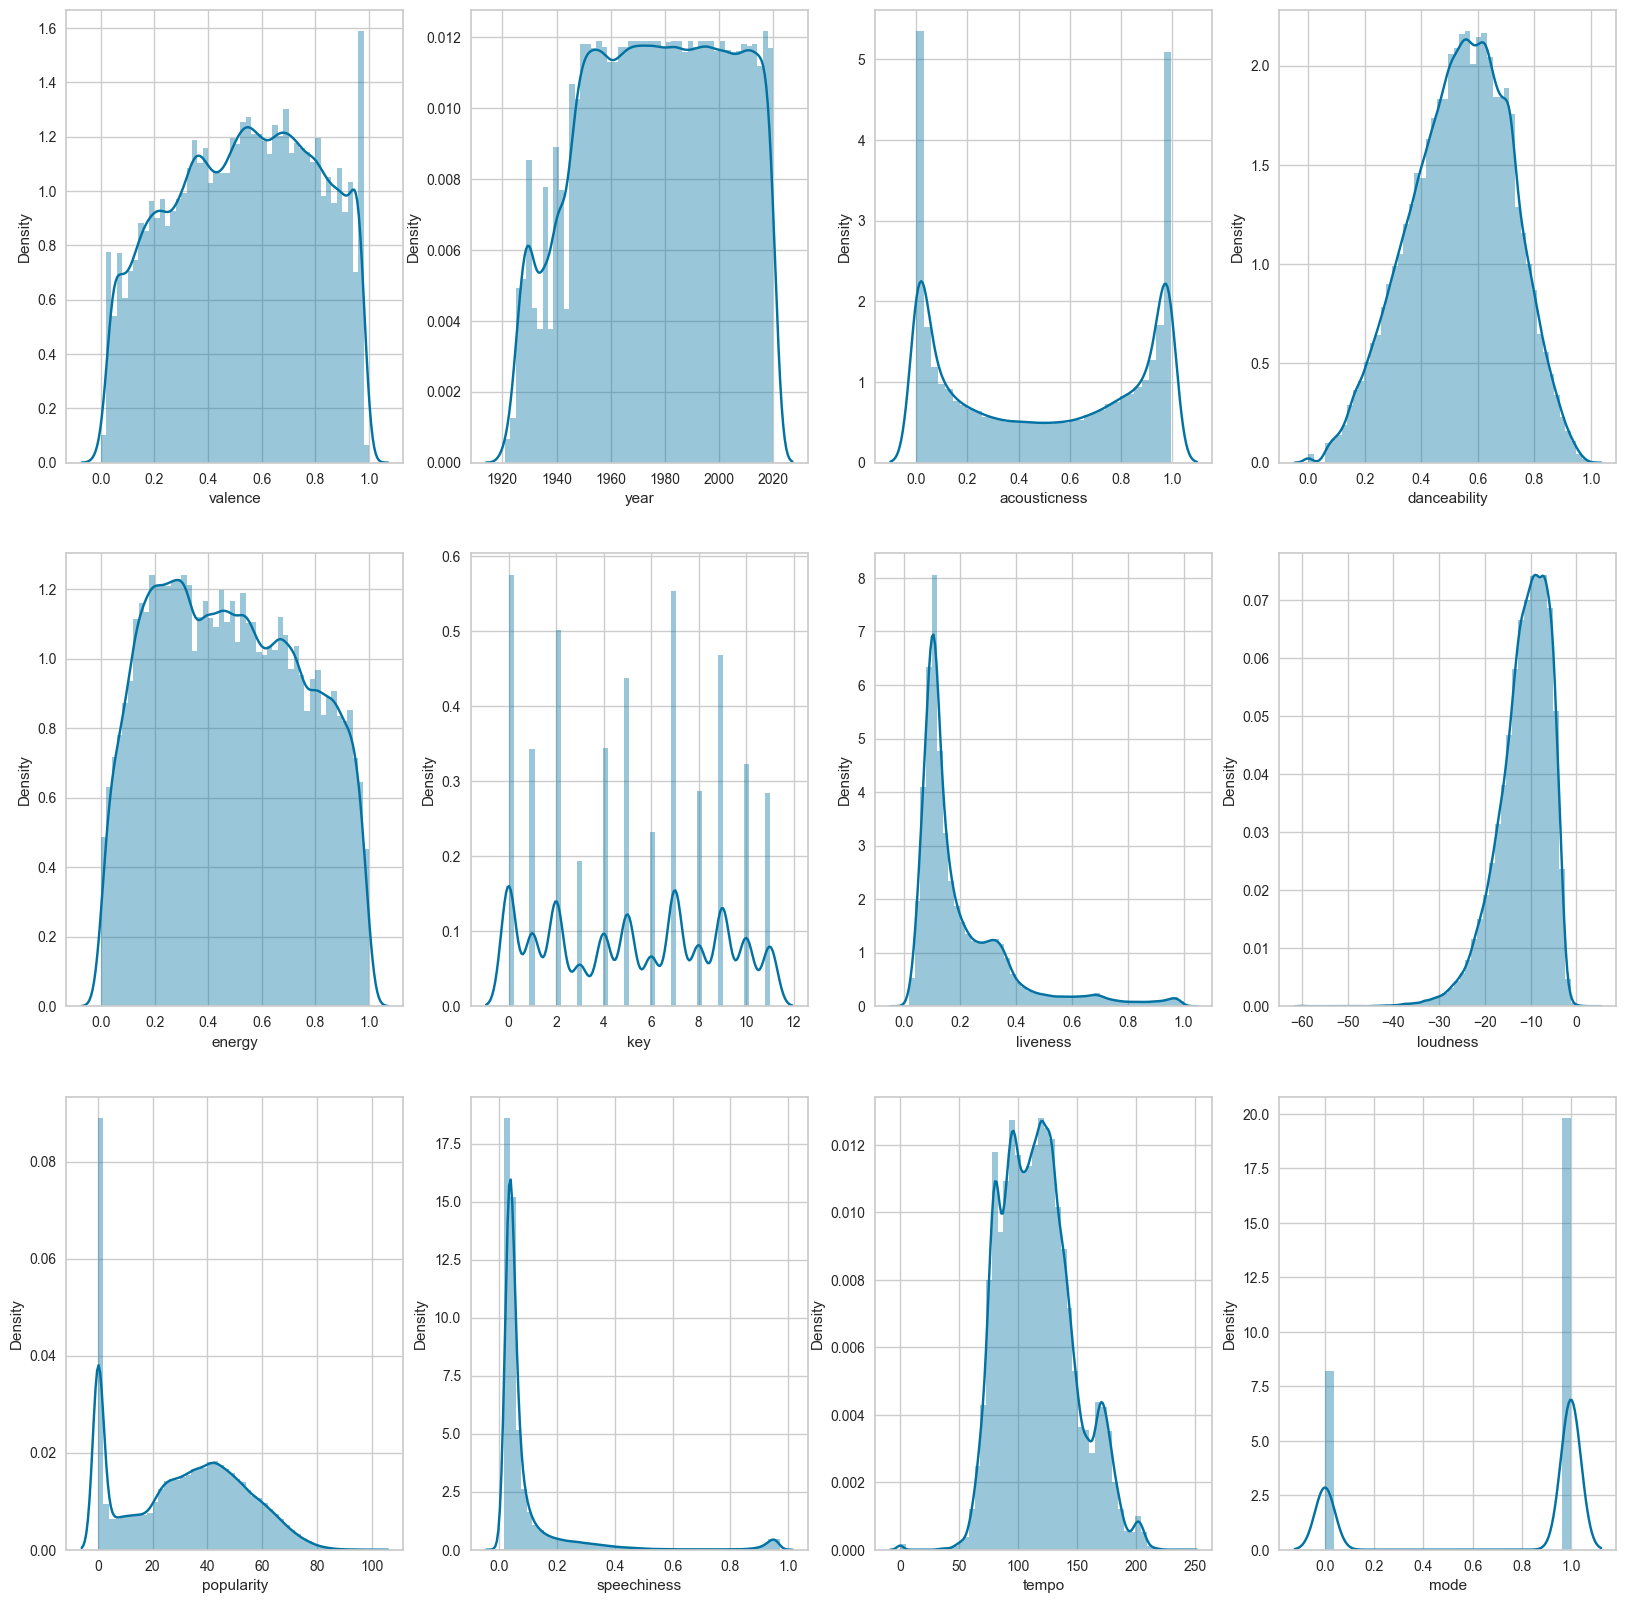

In [ ]:
# Variación de cada atributo de las canciones 
fig,ax = plt.subplots(3,4,figsize=(20,20))

sns.distplot(df_data['valence'],ax=ax[0,0])
sns.distplot(df_data['year'],ax=ax[0,1])
sns.distplot(df_data['acousticness'],ax=ax[0,2])
sns.distplot(df_data['danceability'],ax=ax[0,3])
sns.distplot(df_data['energy'],ax=ax[1,0])
sns.distplot(df_data['key'],ax=ax[1,1])
sns.distplot(df_data['liveness'],ax=ax[1,2])
sns.distplot(df_data['loudness'],ax=ax[1,3])
sns.distplot(df_data['popularity'],ax=ax[2,0])
sns.distplot(df_data['speechiness'],ax=ax[2,1])
sns.distplot(df_data['tempo'],ax=ax[2,2])
sns.distplot(df_data['mode'],ax=ax[2,3])

<Axes: >

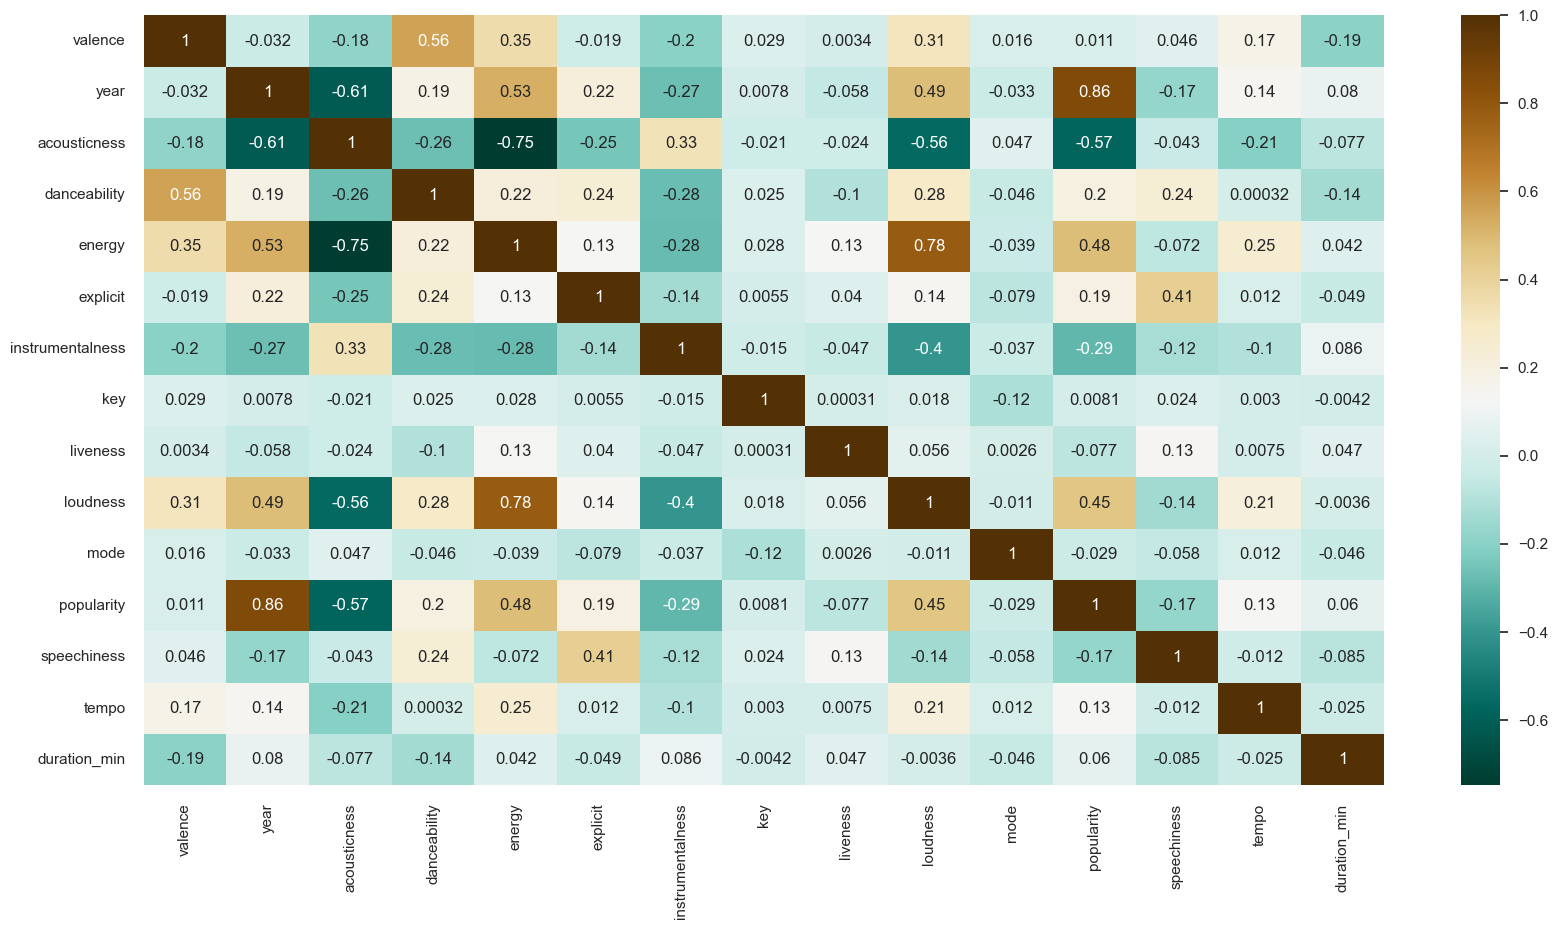

In [ ]:
# Matriz de correlación entre las variables
plt.figure(figsize=(20,10))
sns.set(style="whitegrid")
corr = df_data.corr()
sns.heatmap(corr,annot=True,cmap='BrBG_r',annot_kws={"fontsize":12})

* year, danceability, energy, loudness y tempo son las características más importantes para predecir la popularidad

* Relación entre valence y danceability, entre speechiness y danceability, entre loudness y energy

* acousticness está negativamente correlacionada con energy, loudness y year



Canciones más populares

(array([  0.,  20.,  40.,  60.,  80., 100., 120.]),
 [Text(0.0, 0, '0'),
  Text(20.0, 0, '20'),
  Text(40.0, 0, '40'),
  Text(60.0, 0, '60'),
  Text(80.0, 0, '80'),
  Text(100.0, 0, '100'),
  Text(120.0, 0, '120')])

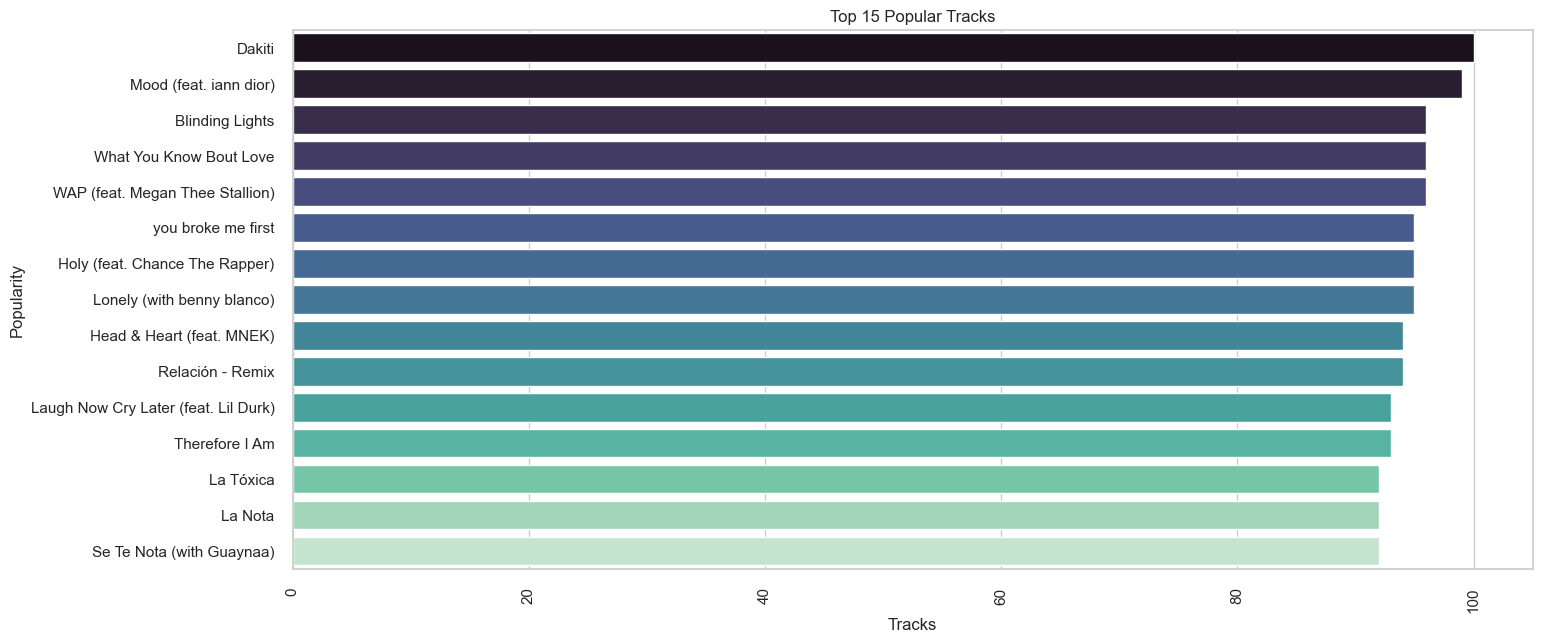

In [ ]:
# 15 Canciones más populares
fig, axis = plt.subplots(figsize = (16,7))

popular = df_data.groupby('name')['popularity'].mean().sort_values(ascending=False).head(15)
axis = sns.barplot(x=popular, y=popular.index, palette='mako', orient = 'h')
axis.set_title('Top 15 Popular Tracks')
axis.set_ylabel('Popularity')
axis.set_xlabel('Tracks')
plt.xticks(rotation = 90)

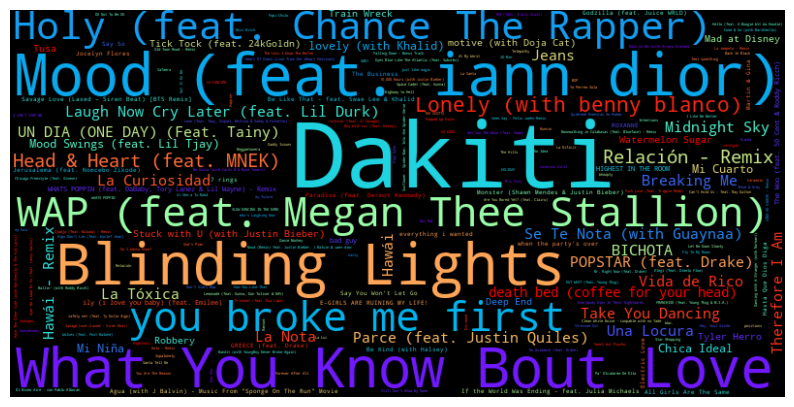

In [ ]:
# wordcloud
top_songs = df_data.groupby('name')['popularity'].mean().sort_values(ascending=False)
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='rainbow').generate_from_frequencies(top_songs)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Artistas más populares

(array([    0.,  2500.,  5000.,  7500., 10000., 12500., 15000., 17500.,
        20000., 22500.]),
 [Text(0.0, 0, '0'),
  Text(2500.0, 0, '2500'),
  Text(5000.0, 0, '5000'),
  Text(7500.0, 0, '7500'),
  Text(10000.0, 0, '10000'),
  Text(12500.0, 0, '12500'),
  Text(15000.0, 0, '15000'),
  Text(17500.0, 0, '17500'),
  Text(20000.0, 0, '20000'),
  Text(22500.0, 0, '22500')])

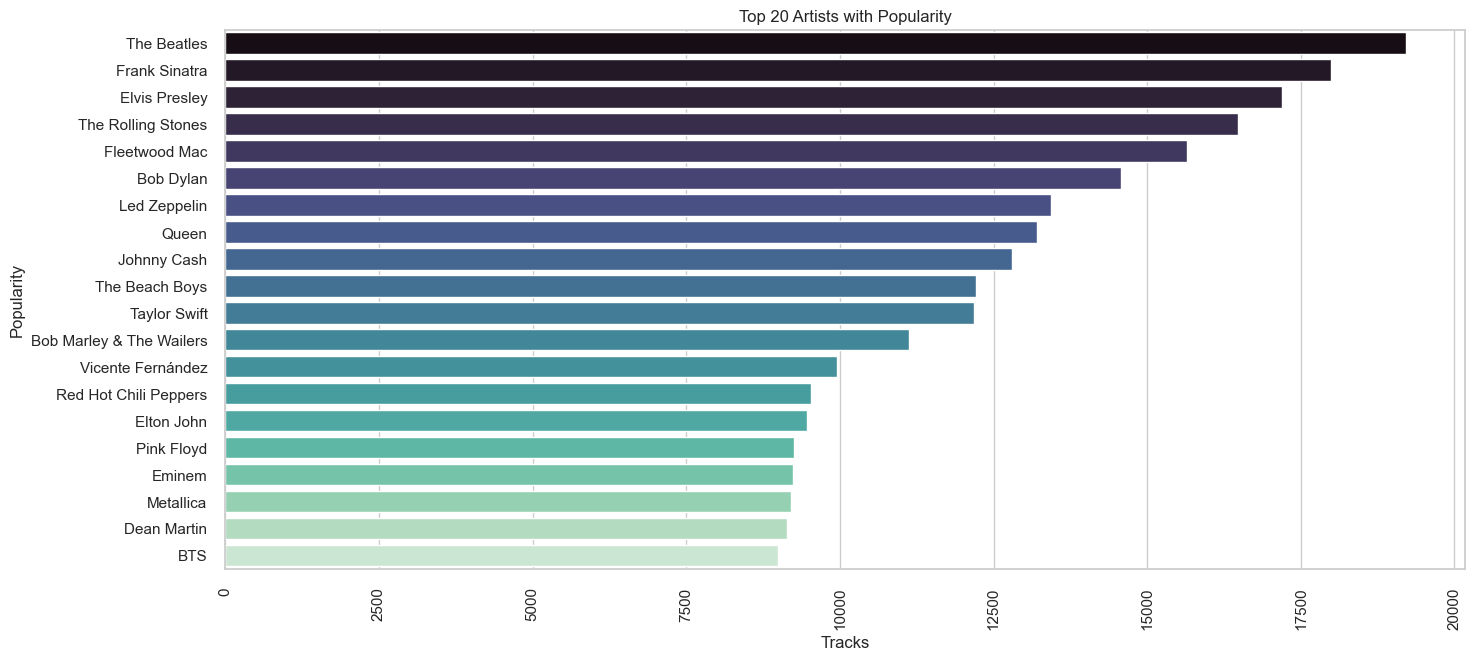

In [ ]:
# Artistas populares
fig, axis = plt.subplots(figsize = (16,7))
popular = df_data.groupby("artists")['popularity'].sum().sort_values(ascending=False)[:20]
axis = sns.barplot(x=popular, y=popular.index, palette="mako", orient = 'h')
axis.set_title('Top 20 Artists with Popularity')
axis.set_ylabel('Popularity')
axis.set_xlabel('Tracks')
plt.xticks(rotation = 90)

Popularidad de The Beatles a lo largo de los años

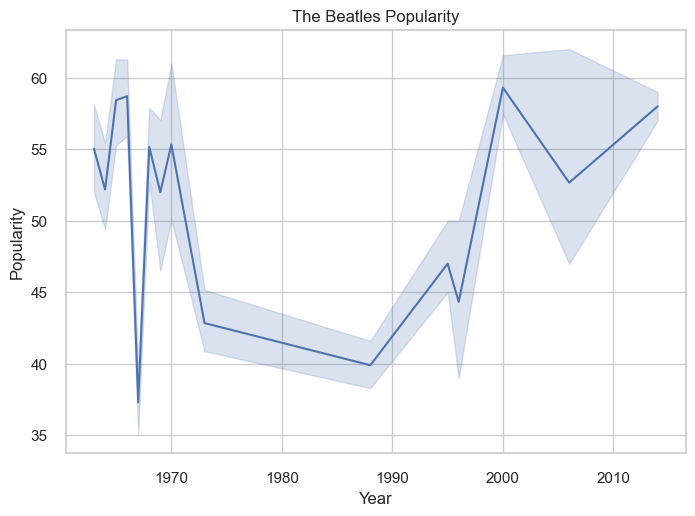

In [ ]:
Beatles = df_data[df_data['artists'] == 'The Beatles']

sns.lineplot(x='year', y='popularity', data=Beatles, color='b')
plt.title('The Beatles Popularity')
plt.xlabel('Year')
plt.ylabel('Popularity')
plt.show()

Popularidad de varios artistas

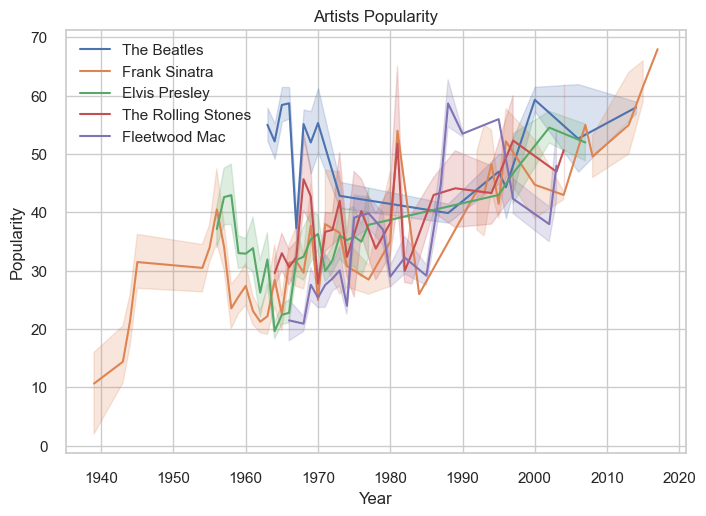

In [ ]:
popular = df_data.groupby("artists")['popularity'].sum().sort_values(ascending=False)[:5]

for idx, artist in enumerate(popular.index):
    x = df_data[df_data['artists'] == str(artist)]
    sns.lineplot(x='year', y='popularity', data=x, label=artist)

plt.title('Artists Popularity')
plt.xlabel('Year')
plt.ylabel('Popularity')
plt.legend(loc='best')
plt.show()
    

Atributos del audio a través de los años

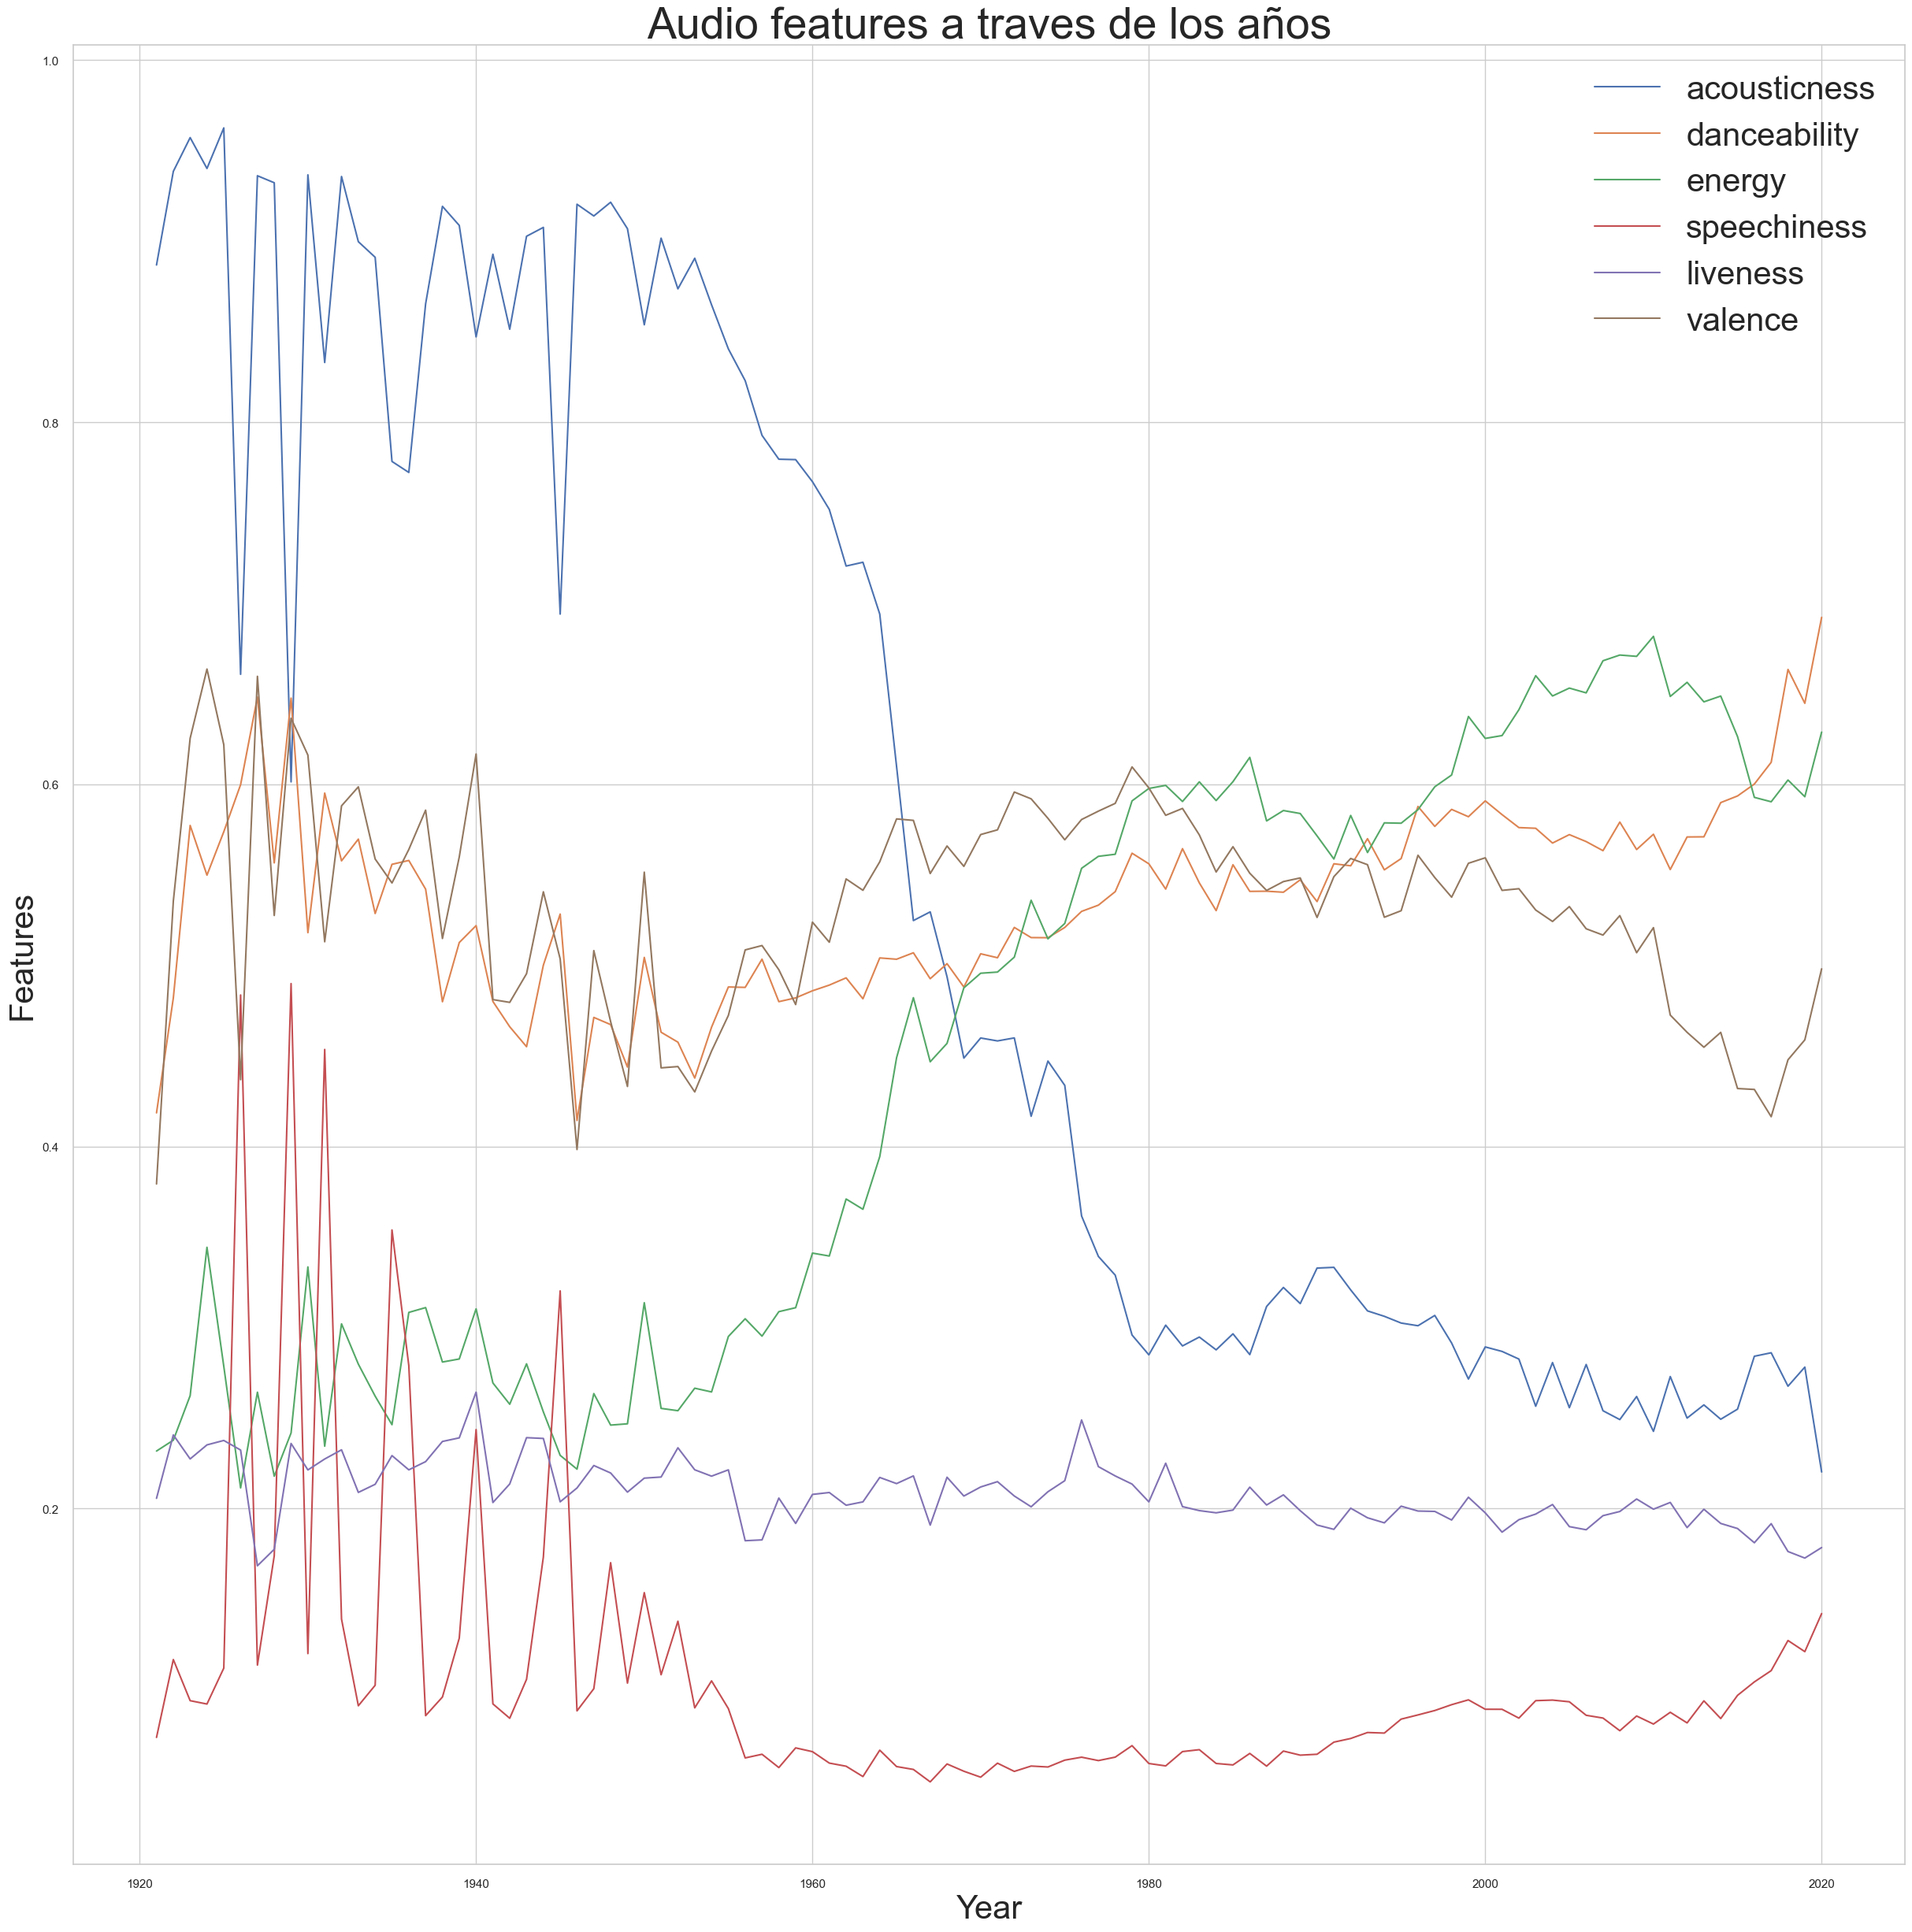

In [ ]:
columns = ['acousticness','danceability','energy','speechiness','liveness','valence']

plt.figure(figsize=(30,30))

for c in columns:
    x = df_data.groupby('year')[c].mean()
    sns.lineplot(x=x.index, y=x, label=c)
plt.title('Audio features a traves de los años', fontsize=40)
plt.xlabel('Year',fontsize=30)
plt.ylabel('Features',fontsize=30)
plt.legend(prop={'size': 30}, loc = 'best')
plt.show()

##### Audio Features a través de los años

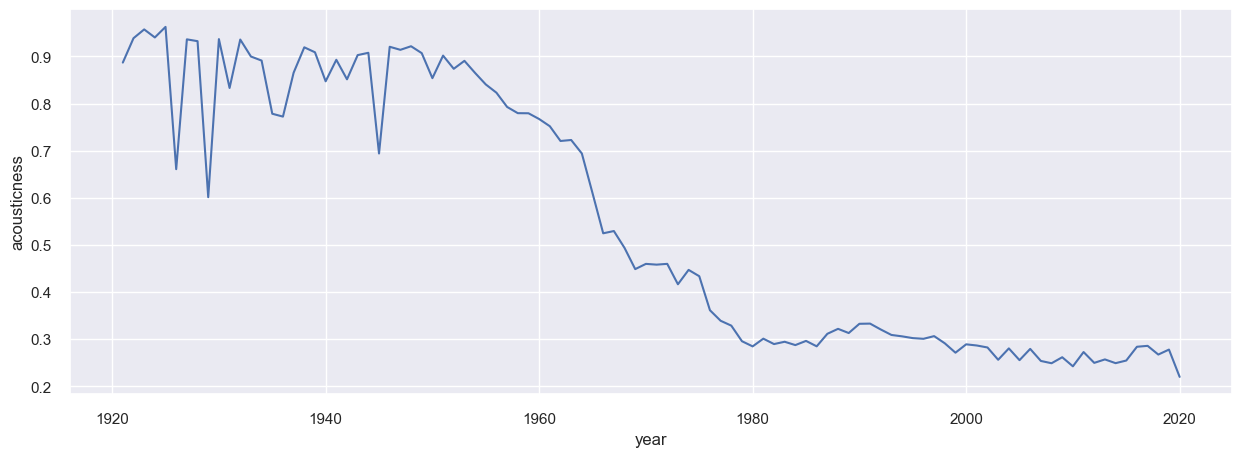

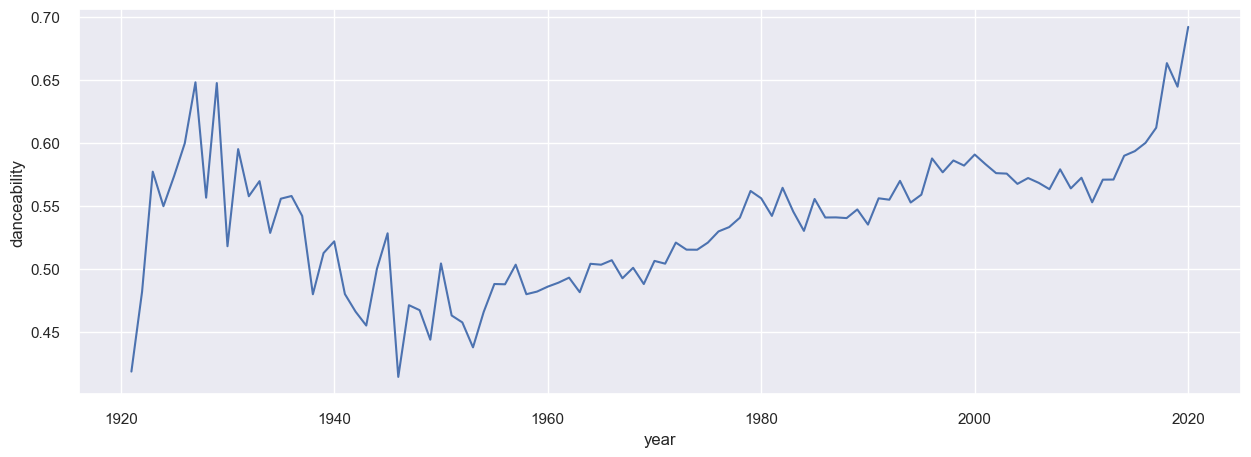

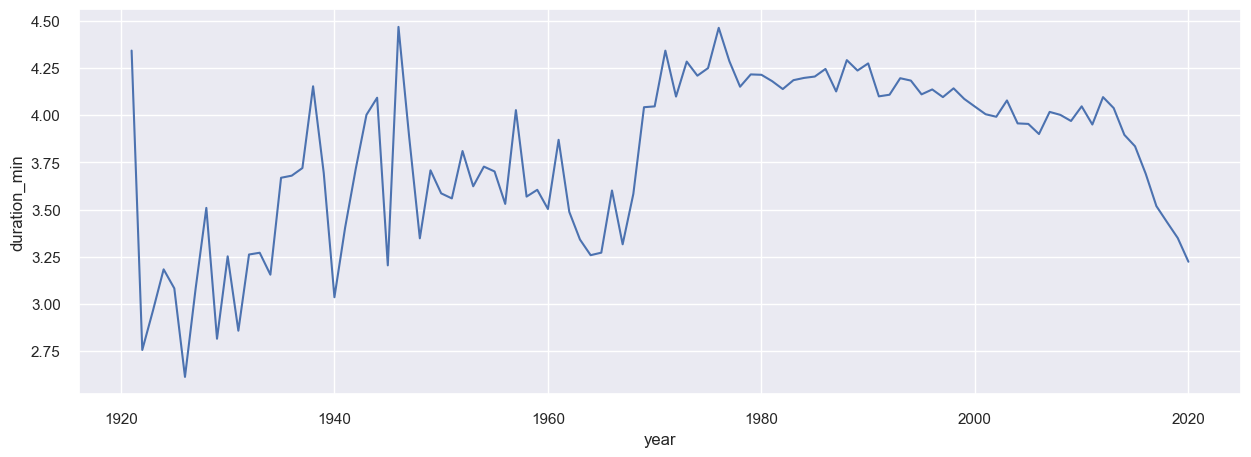

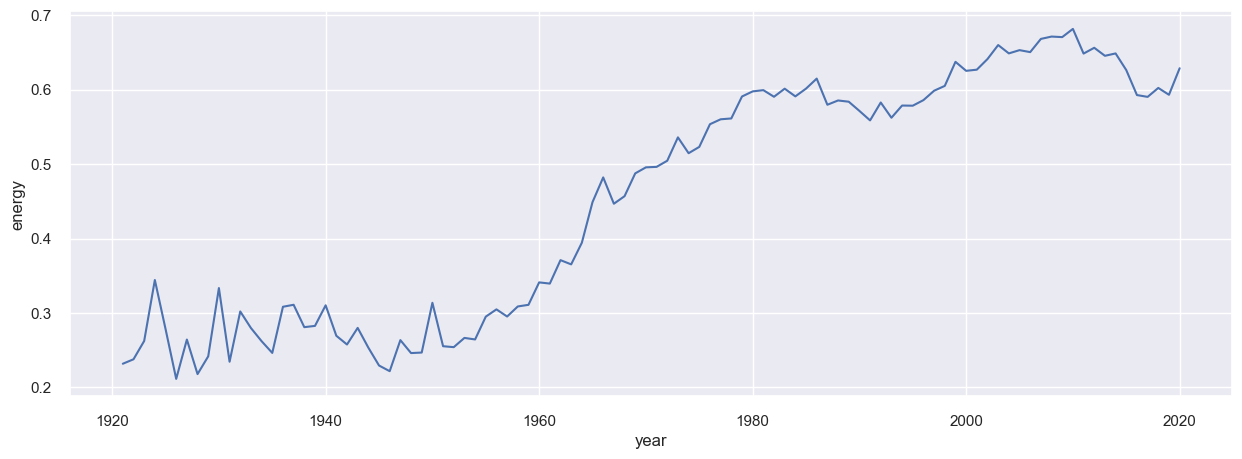

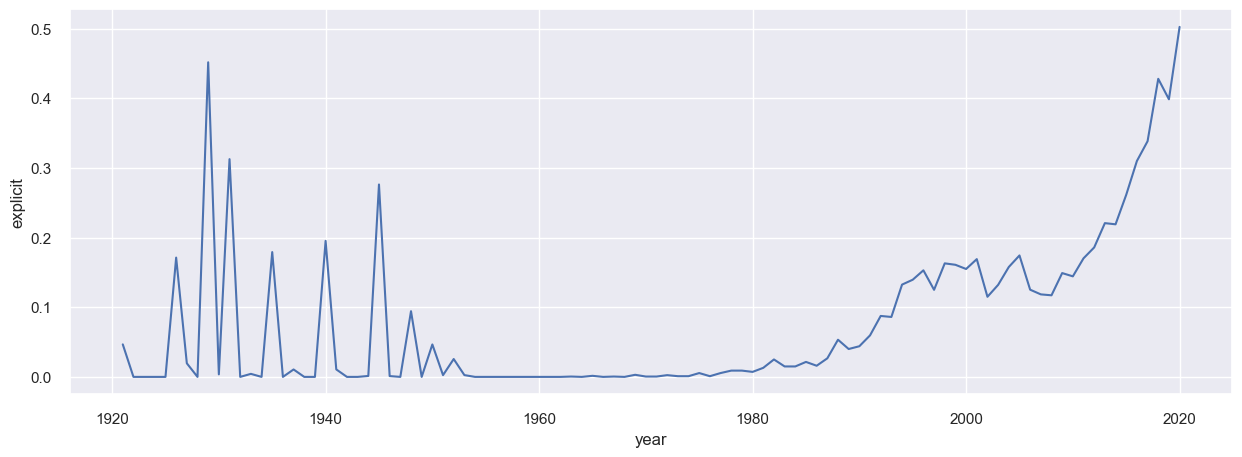

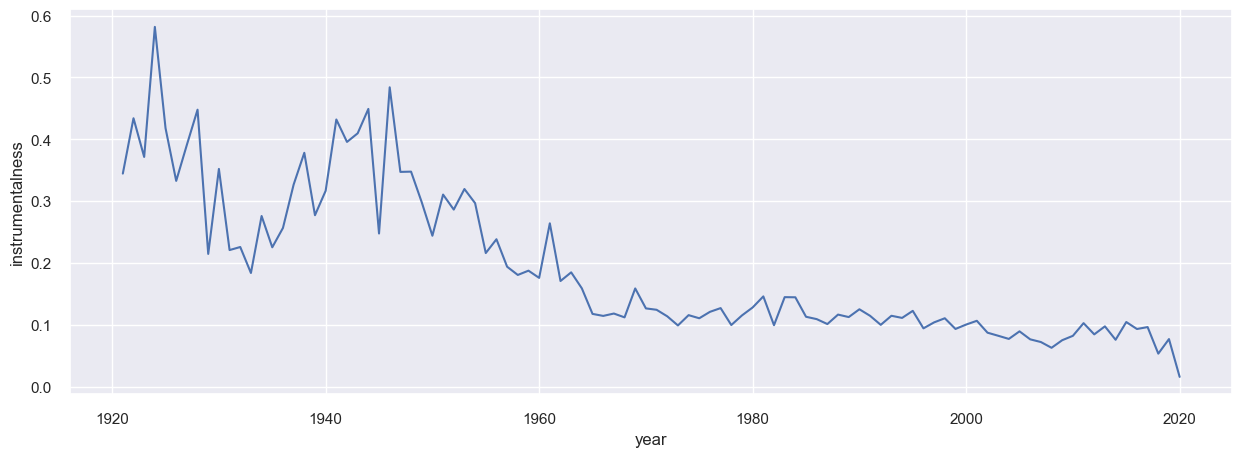

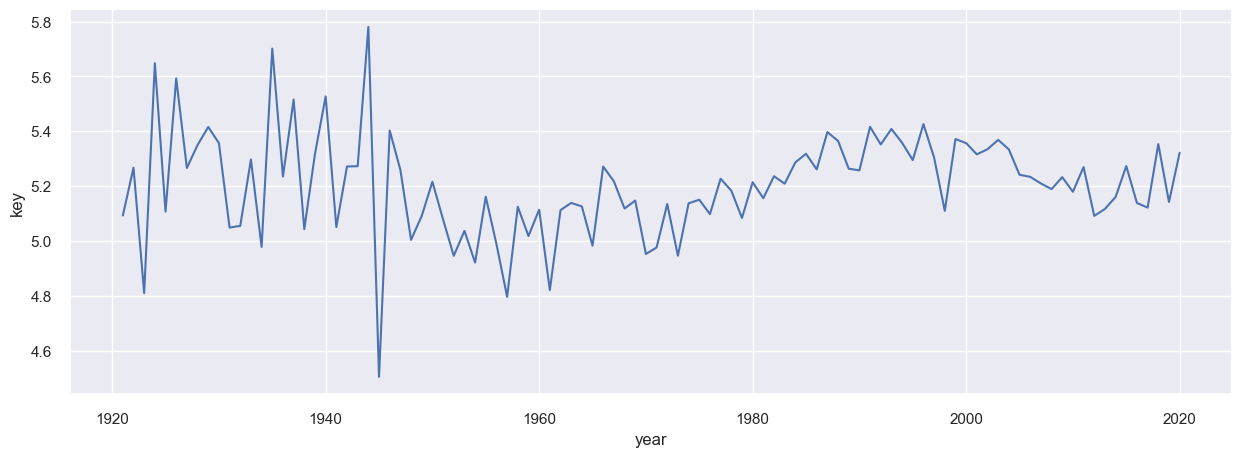

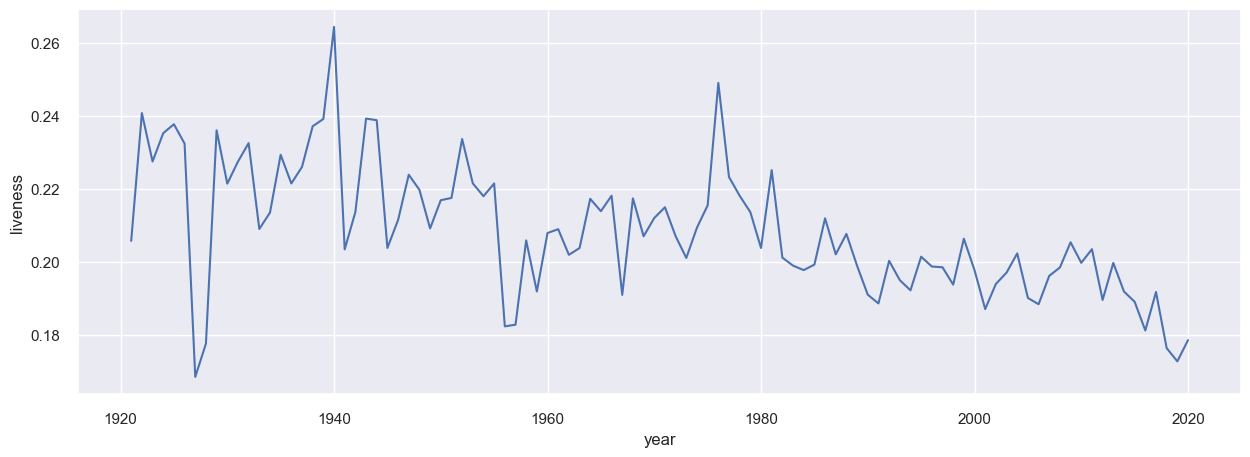

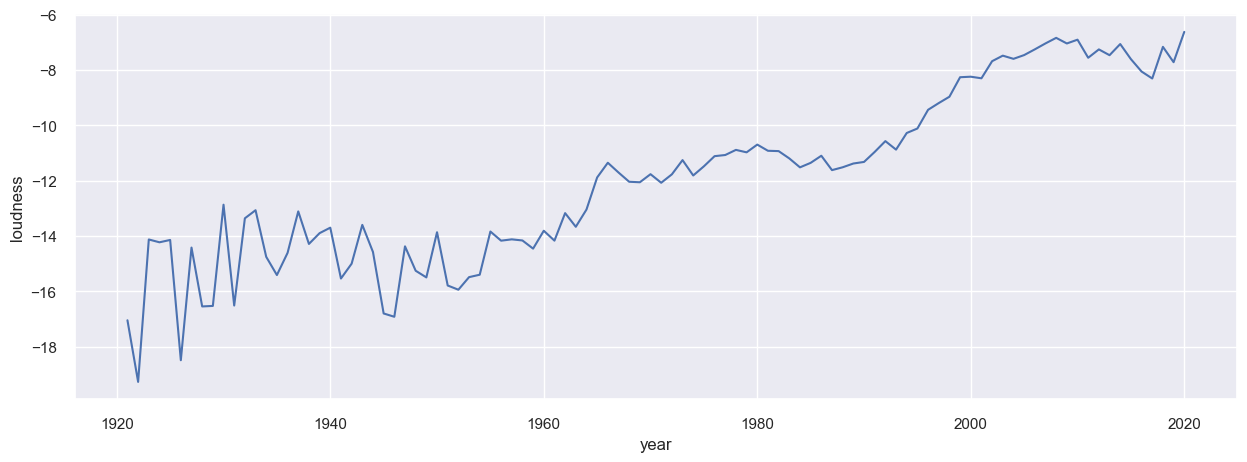

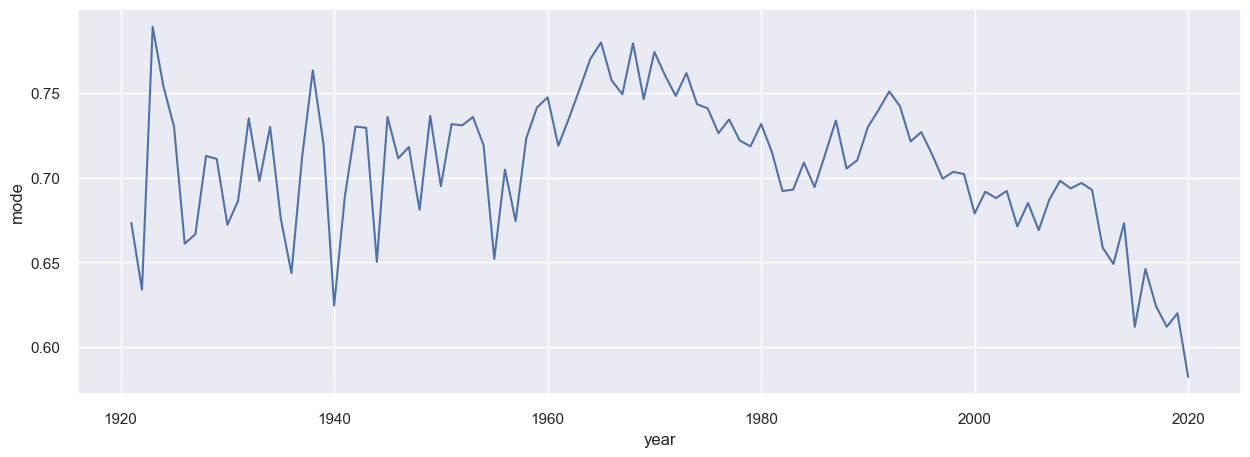

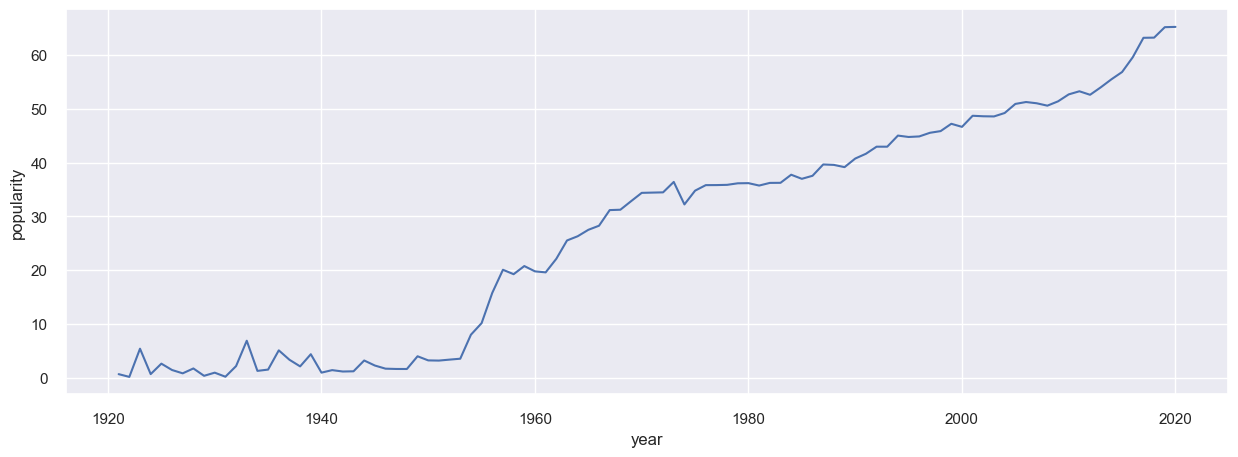

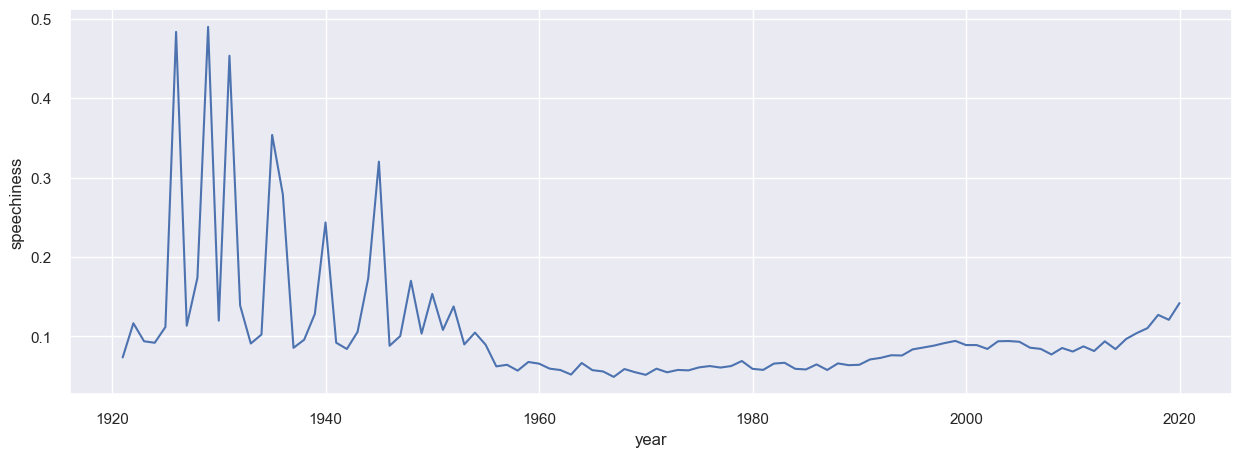

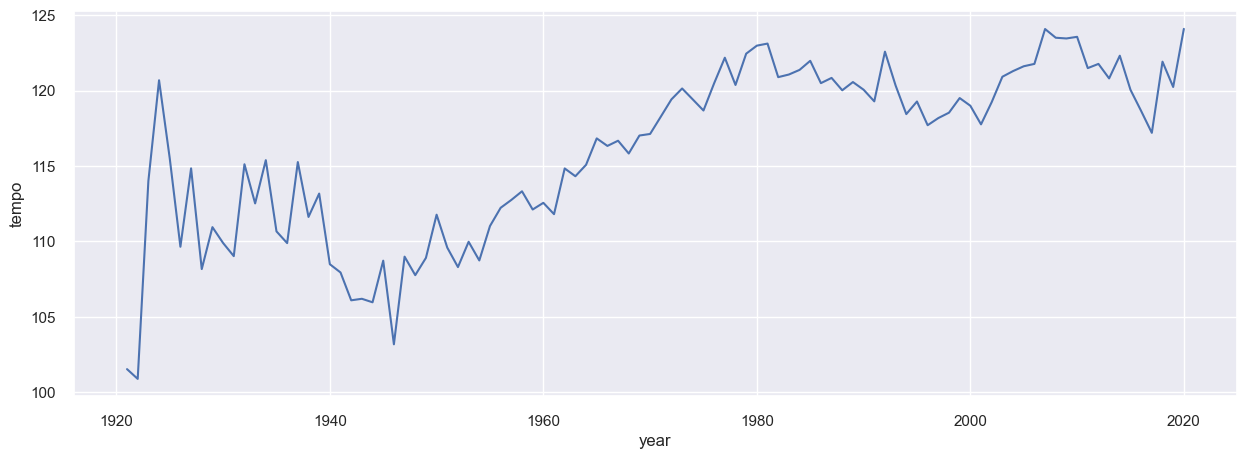

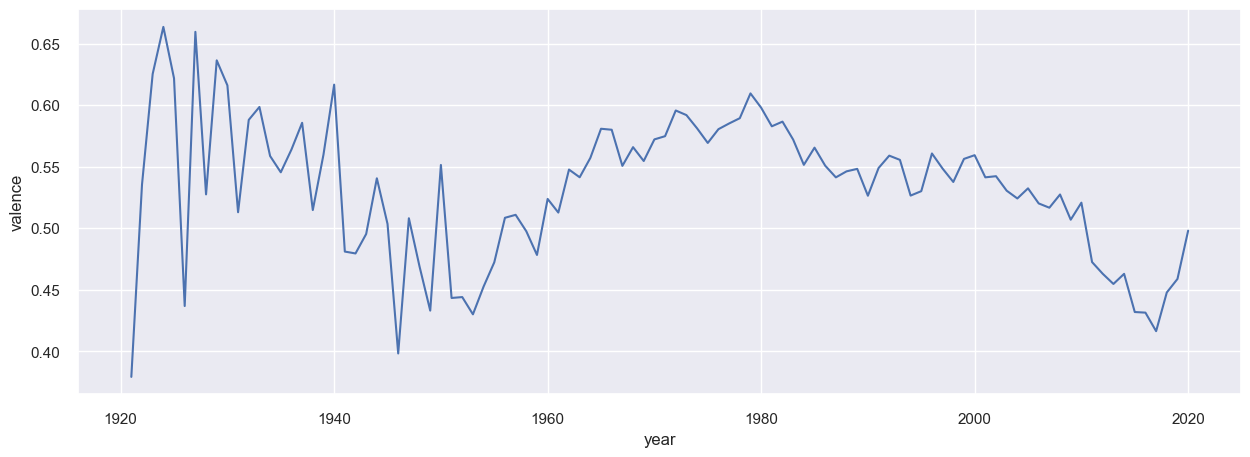

In [ ]:
columns = ['acousticness','danceability', 'duration_min', 'energy', 'explicit',
            'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
            'popularity', 'speechiness', 'tempo', 'valence']

for col in columns:
    y = df_data.groupby('year')[col].mean()
    x = y.index
    plt.figure(figsize=(15, 5))
    sns.set_style("darkgrid")
    sns.lineplot(x=x, y=y)


##### _____

Artistas con el mayor número de canciones

In [ ]:
y = pd.DataFrame(df_data['artists'].value_counts().head()).reset_index()
y.columns = ['Artists','Songs_Count']
y

,Artists,Songs_Count
0,Эрнест Хемингуэй,1211
1,Эрих Мария Ремарк,1068
2,Francisco Canaro,942
3,Frank Sinatra,630
4,Ignacio Corsini,628


Número de canciones publicadas por año

year    2103
dtype: int64
year    2018
dtype: int64


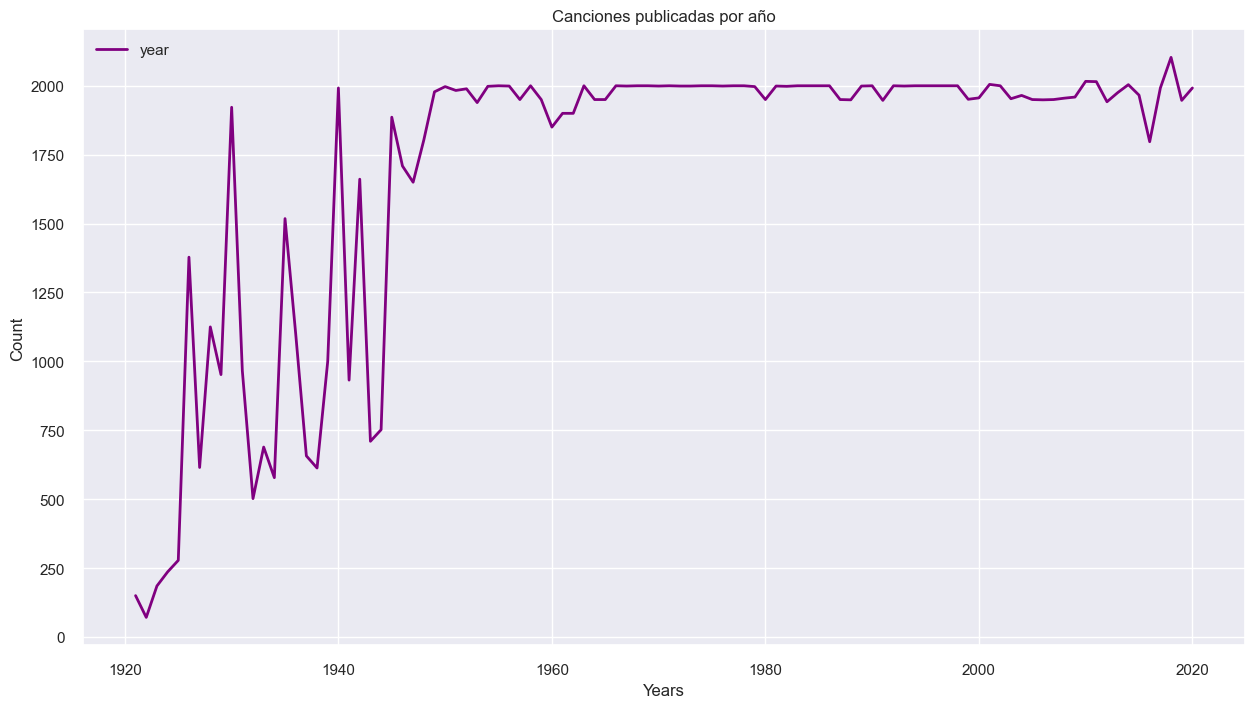

In [ ]:
year = pd.DataFrame(df_data['year'].value_counts())
year = year.sort_index()

print(year.max())
print(year.idxmax())

ax = year.plot(kind='line',figsize=(15,8) , color='purple', linewidth=2)
plt.title('Canciones publicadas por año')
plt.xlabel('Years')
plt.ylabel('Count')
ax.axes.get_xaxis().set_visible(True)

### Machine Learning

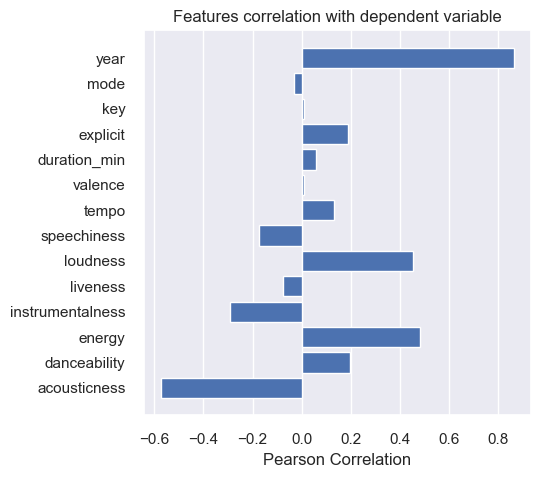

<Axes: title={'center': 'Features correlation with dependent variable'}, xlabel='Pearson Correlation'>

In [ ]:
feature_names = ['acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence','duration_min','explicit','key','mode','year']

# Correlación de las características con la popularidad
X, y = df_data[feature_names], df_data['popularity']

# Lista de los atributos
features = np.array(feature_names)

# Visualizador de variables
visualizer = FeatureCorrelation(labels=features)

plt.rcParams['figure.figsize']=(5,5)
visualizer.fit(X, y)        
visualizer.show()  

* mode, speechiness, liveness, instrumentalness, acousticness tienen correlación negativa con la popularidad

#### Preprocesamiento

In [ ]:
# Extracción del dataset
cols = list(pd.read_csv('data.csv', nrows =1))
df = pd.read_csv('data.csv', usecols=[i for i in cols if i not in ['id','name','release_date']])

# Quitar duplicados
df = df[~df.duplicated()==1]

# Partición de los datos
# Label = popularidad
X_train, X_test, y_train, y_test = train_test_split(df.drop('popularity', axis=1), df['popularity'], test_size=0.2, random_state=0)

In [ ]:
X_train.head()

,valence,year,acousticness,artists,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,speechiness,tempo
84817,0.135,1982,0.6960,['Simon & Garfunkel'],0.311,284867,0.234,0,0.000097,3,0.978,-16.027,1,0.0301,76.270
50640,0.938,1987,0.0044,"['Dead Or Alive', 'Phil Harding']",0.675,267093,0.783,0,0.012900,6,0.377,-10.243,0,0.0468,128.530
4471,0.505,1944,0.4850,"['Dale Carnegie', 'Till Hagen', 'Stefan Kamins...",0.707,649493,0.322,0,0.000000,10,0.181,-16.543,0,0.9460,108.717
161469,0.239,1974,0.4200,['Eric Clapton'],0.331,289373,0.366,0,0.001380,7,0.984,-11.041,1,0.0362,135.659
145590,0.340,1969,0.5880,['Allman Brothers Band'],0.336,303521,0.411,0,0.003650,4,0.224,-13.638,1,0.0406,129.728


In [ ]:
y_train.head()

84817     40
50640     48
4471      13
161469    23
145590    19
Name: popularity, dtype: int64

Es necesario:

* tener un indicador para identificar al artista de manera numérica
* eliminar los ceros en las columnas 
* estandarizar el criterio instrumental con valores numéricos
* usar OneHotEncoder de sklearn para crear los dummies
* aplicar MinMaxScaler para obtener las características relevantes
* escalar la popularidad (target)

In [ ]:
# Numero de artistas diferentes 
num_artists = df['artists'].nunique()
num_artists

34088

Transformación de las características

In [ ]:
class Artists:
    """
    El transformador recibe un DF con el atributo 'artists' de tipo objeto
    y lo convierte a un valor flotante de la siguiente manera:
        1. Reemplaza el dato con la popularidad media del artista
        2. Reemplaza valores donde el artista aparece menos que MinCnt con y.mean()
        3. Reemplaza valores donde el artista aparece más que MaxCnt con 0 
      
      Parametros: 
      MinCnt (int): Número min de veces que el artista aparece en el dataset, default = 3
      MaxCnt (int): Número max de veces que el artista aparece en el dataset, default = 600

      Return: 
      Un dataframe con la caracteristica 'artists' como flotantes
    """
    def __init__(self, MinCnt = 3.0, MaxCnt = 600.0):
        self.MinCnt = MinCnt
        self.MaxCnt = MaxCnt
        self.artists_df = None

    def fit (self, X, y):
        self.artists_df =  y.groupby(X.artists).agg(['mean', 'count'])
        self.artists_df.loc['unknown'] = [y.mean(), 1]
        self.artists_df.loc[self.artists_df['count'] <= self.MinCnt, 'mean'] = y.mean()
        self.artists_df.loc[self.artists_df['count'] >= self.MaxCnt, 'mean'] = 0
        return self

    def transform(self, X, y=None):
        X['artists'] = np.where(X['artists'].isin(self.artists_df.index), X['artists'], 'unknown')
        X['artists'] = X['artists'].map(self.artists_df['mean'])
        return X

In [ ]:
# Transformación de la instrumentalidad

def instrumental(X):
    X['instrumentalness'] = list(map((lambda x: 1 if x < 0.1 else (3 if x > 0.95 else 2)), X.instrumentalness))
    
    
class Tempo():
    """
    Elimina los valores de 0 en la columna Tempo y lo reemplaza
    con la mediana o el promedio de los valores especificados
    """
    def __init__(self, method='median'):
        self.method = method

    def transform(self, X):
        if self.method == 'median':
            X.loc[X['tempo']==0, 'tempo'] = X.loc[X['tempo']>0, 'tempo'].median()
        elif self.method == 'mean':
            X.loc[X['tempo']==0, 'tempo'] = X.loc[X['tempo']>0, 'tempo'].mean()
        else:
            raise Exception("Method can be 'median' or 'mean' only!")
        return X

In [ ]:
# Transformación de la clase Artists 
artists_transformer = Artists(MinCnt=2)
X_train = artists_transformer.fit(X_train, y_train).transform(X_train, y_train)
X_test = artists_transformer.transform(X_test, y_test)

# Transformación del criterio de instrumentalidad
instrumentalness_tranformer = FunctionTransformer(instrumental)
instrumentalness_tranformer.transform(X_train)
instrumentalness_tranformer.transform(X_test)

# Transformación de la clase Tempo 
tempo_transformer = Tempo()
X_train = tempo_transformer.transform(X_train)
X_test = tempo_transformer.transform(X_test)

One Hot Encoder

In [ ]:
ohe = OneHotEncoder(categories='auto', drop='first')

# Train
feature_array = ohe.fit_transform(X_train[['instrumentalness','key']]).toarray()
columns_key = ['key_'+str(i) for i in list(set(X_train['key'].values))[1:]]
instrumentalness_key = ['ins_'+str(i) for i in list(set(X_train['instrumentalness'].values))[1:]]
feature_labels = columns_key + instrumentalness_key
feature_labels = np.concatenate((feature_labels), axis=None)
features = pd.DataFrame(feature_array, columns = feature_labels, index = X_train.index)
X_train = pd.concat([X_train, features], axis=1).drop(['key','instrumentalness'], axis=1)

# Test
feature_array = ohe.fit_transform(X_test[['instrumentalness','key']]).toarray()
columns_key = ['key_'+str(i) for i in list(set(X_test['key'].values))[1:]]
instrumentalness_key = ['ins_'+str(i) for i in list(set(X_test['instrumentalness'].values))[1:]]
feature_labels = columns_key + instrumentalness_key
feature_labels = np.concatenate((feature_labels), axis=None)
features = pd.DataFrame(feature_array, columns = feature_labels, index = X_test.index)
X_test = pd.concat([X_test, features], axis=1).drop(['key','instrumentalness'], axis=1)

MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
cols = ['artists','duration_ms','loudness','tempo']
X_train[cols] = scaler.fit_transform(X_train[cols])
X_test[cols] = scaler.fit_transform(X_test[cols])

Normalización de la popularidad

In [ ]:
y_train = y_train / 100
y_test = y_test / 100

#### Modelos ML

##### Decision Tree Regressor

In [ ]:
decisionTree = DecisionTreeRegressor()
decisionTree.fit(X_train, y_train)

y_pred = decisionTree.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
score = decisionTree.score(X_test, y_test)

print(f'Root Mean Squared Error for prediction: {rmse}')
print(f'R2 score for prediction: {r2}')
print(f'Mean Absolut Error for prediction: {mae}')
print(f'Score: {score}')


Root Mean Squared Error for prediction: 0.13202343129344574
R2 score for prediction: 0.6315297320269702
Mean Absolut Error for prediction: 0.08775469293731314
Score: 0.6315297320269702


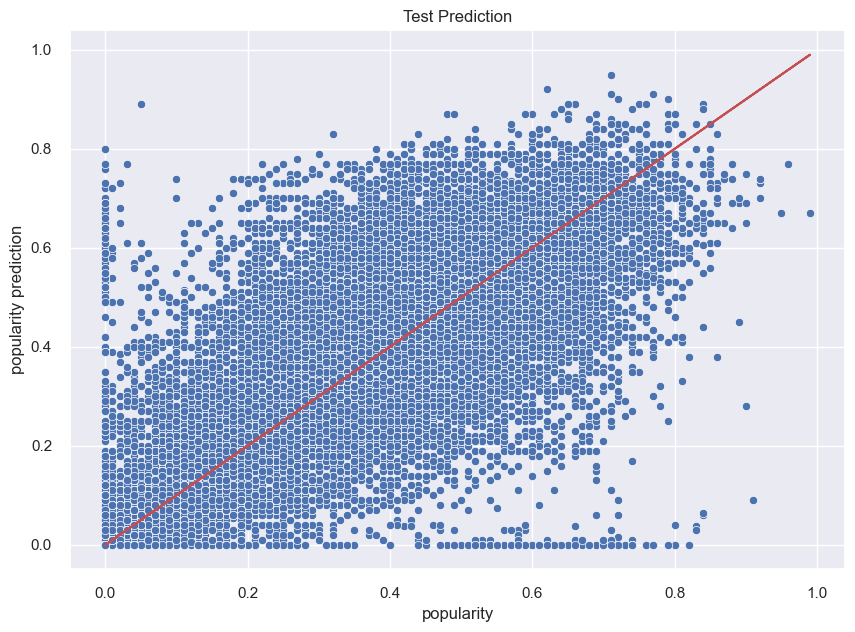

In [ ]:
# Gráfica de popularidad
plt.rcParams['figure.figsize']=(10,7)
ax = sns.scatterplot(x=y_test, y=y_pred)
ax.plot(y_test, y_test, 'r')
ax.set_ylabel('popularity prediction')
ax.set_title('Test Prediction')
plt.show()

##### Random Forest Regresor

In [ ]:
randomForest = RandomForestRegressor(n_estimators=10)
randomForest.fit(X_train, y_train)

y_pred = randomForest.predict(X_test)
#rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
score = randomForest.score(X_test, y_test)

#print(f'Root Mean Squared Error for prediction: {rmse}')
print(f'R2 score for prediction: {r2}')
print(f'Mean Absolut Error for prediction: {mae}')
print(f'Score: {score}')

R2 score for prediction: 0.8030437132711048
Mean Absolut Error for prediction: 0.06750986636800929
Score: 0.8030437132711048


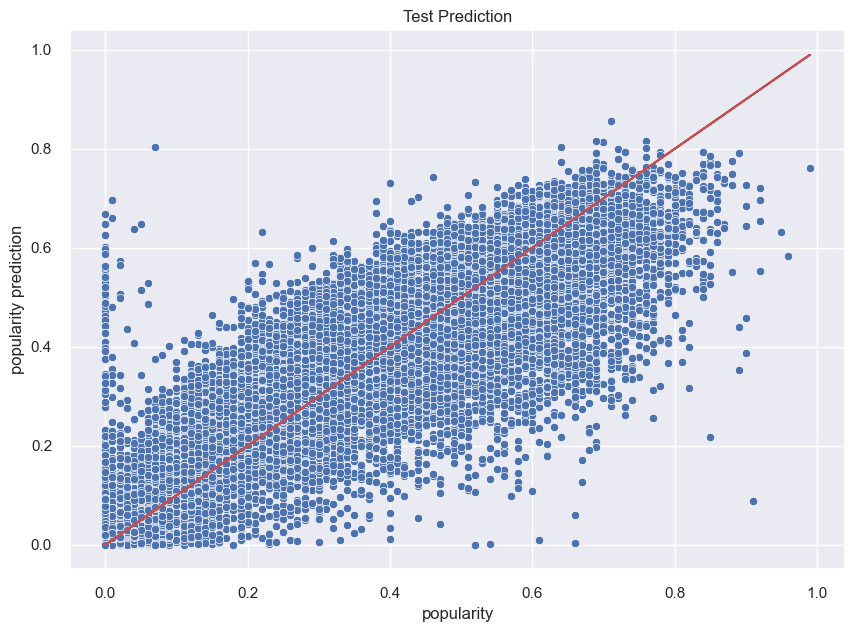

In [ ]:
# Gráfica de popularidad
plt.rcParams['figure.figsize']=(10,7)
ax = sns.scatterplot(x=y_test, y=y_pred)
ax.plot(y_test, y_test, 'r')
ax.set_ylabel('popularity prediction')
ax.set_title('Test Prediction')
plt.show()